### Climate change velocity

Step 1: define some metrics to characterize the distribution like the zero growth isoline or peak krill growth potential isoline.

Step 2: Take the latitudinal position of the metric and plot it as a time series

Step 3: Compute the velocity: the distance between where it ends up and where it started and then divide by the amount of time and you have a velocity



#### Krill Distribution Metrics

In [1]:
from itertools import product

import numpy as np
import xarray as xr

import pop_tools
import xpersist as xp

import util

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar 
from matplotlib import ticker, cm
from matplotlib.ticker import FormatStrFormatter

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean as cmo

plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
variables = ['SST', 'Chl_surf', 'KGP']

ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[variables].sel(length = 40).where(ds_djf.TLAT <= -45)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length     float64 40.0
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

Reduce the dimensionality. Looking at the half polar diagrams, what you could do is take each column in this plot, and then interpolate a particular… Just use linear interpolation defined by your reference point of interest. The growth potential on you might pick zero or some other reference. So you pick zero, and loop over the columns in that plot and find the latitude of each interpolate the latitude at each zero. Just use numpy interp. To extract that latitude.

What you should do is construct a time series of the latitude position of the zero growth contour for each ensemble member for the entire integration: Use linear interpolation to pick out the latitude in a continuous sense given that you know the value of that function at the model grid points, so interpolate between the model grid points. Based on linear interpolations exactly 0 or whatever value you pick. And then you can plot and entire time series of the full ensemble that is the latitude of zero growth potential. And so you would just use some zonal mean over whatever sector you choose.

Then you can plot that latitude as a function of time for every ensemble member and then you can do statistics on it, you can do a TOE calculation and you can compete a trend which is that the unit of the trend would be degrees latitude overtime. For reference 1° and latitude is 111 km so you can actually have a distance for time which gives you velocity the trend is the velocity


In [3]:
# take the mean across all members and all longitudes
ds_djf_za = ds_djf.mean('nlon').mean('member_id')
ds_djf_za

<xarray.Dataset>
Dimensions:   (nlat: 93, time: 180)
Coordinates:
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
    length    float64 40.0
Dimensions without coordinates: nlat
Data variables:
    SST       (time, nlat) float64 dask.array<chunksize=(180, 93), meta=np.ndarray>
    Chl_surf  (time, nlat) float64 dask.array<chunksize=(180, 93), meta=np.ndarray>
    KGP       (time, nlat) float64 dask.array<chunksize=(180, 93), meta=np.ndarray>

In [4]:
v = 'KGP'

thresh_val = 0
lat = ds_djf.TLAT.values[:, 0]

LAT_of_val = xr.DataArray(np.ones((len(ds_djf_za.time)))*np.nan,
                          dims=('time'),
                          coords={'time': ds_djf.time},
                          attrs={'long_name': 'Latitude of threshold'}
                         )

x = ds_djf_za[v].values

for l in range(len(ds_djf_za.time)):
    Iabv = np.where(x[l, :] < thresh_val)[0]
    ndx = [Iabv[0]-1, Iabv[0]]
    LAT_of_val.values[l] = np.interp(thresh_val, x[l, ndx], lat[ndx])

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


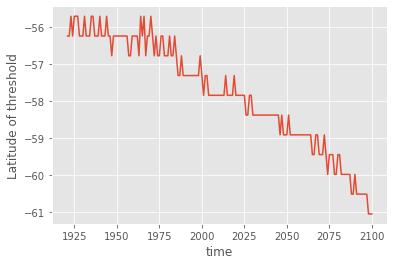

In [5]:
LAT_of_val.plot()

Then you can plot that latitude as a function of time for every ensemble member and then you can do statistics on it, you can do a TOE calculation and you can compute a trend which is that the unit of the trend would be degrees latitude overtime. For reference 1° and latitude is 111 km so you can actually have a distance for time which gives you velocity the trend is the velocity. Tlat is a matrix of a lon by and lat - if you subset so that you’re just looking at the southern hemisphere, every column in this matrix is identical. Therefore you can just pull out the first column to be a latitude coordinate. You do that 

## Grid up locations

In [8]:
grid = pop_tools.get_grid('POP_gx1v6')
#grid
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
grid = grid.isel(nlat=lat_slice)
#grid

#### Regions:
1. Atlantic /Basin: 50°W to 30°E
2. SW Atlantic sector: 30°W to 70°W
* eastern (30–50 W)
* western (50–70 W) 
* SW Atlantic-Peninsula (10 to 80°W)
5. Indian: 30E - 160E
6. Paciﬁc: 160E - 30W


In [9]:
# define a list of tuples describing our regions: (region_name, logical_array)
so_logic = (grid.TLAT <= -45)
mask_logic = [
    ('Southern Ocean', so_logic), 
    ('Atlantic Basin', so_logic & ((grid.TLONG > 310) | (grid.TLONG < 30))), # 50W to 30E
    ('SW Atlantic', so_logic & ((grid.TLONG > 290) | (grid.TLONG < 30))),  # 70W - 30E
    
    ('SW Eastern', so_logic & ((grid.TLONG < 330) & (grid.TLONG > 310))), #30W (310) - 50W (330) # # 30 - 70 70+180 = 250 // 30+180 = 210
    ('SW Western', so_logic & ((grid.TLONG < 330) & (grid.TLONG > 290))), #50W (330) - 70W (290) # # 30 - 70 70+180 = 250 // 30+180 = 210
    ('SW AP', so_logic & ((grid.TLONG < 350) & (grid.TLONG > 280))),   # 10W (350) to 80°W (280)  
]
# create a region coordinate with the region names
region = xr.DataArray(
    [t[0] for t in mask_logic], 
    dims=('region'), 
)
nregion = len(region)

# create a masked array array
masked_area = xr.DataArray(
    np.zeros((nregion,)+grid.TLAT.shape), 
    dims=('region',)+grid.TLAT.dims,
    coords={'region': region},
    name='masked_area',
)
for i, name_logic in enumerate(mask_logic):
    masked_area.data[i, :, :] = grid.TAREA.where(name_logic[1]).fillna(0.).where(grid.KMT>0)

# subset to the lat range from above
masked_area = masked_area.isel(nlat=lat_slice)
#masked_area  

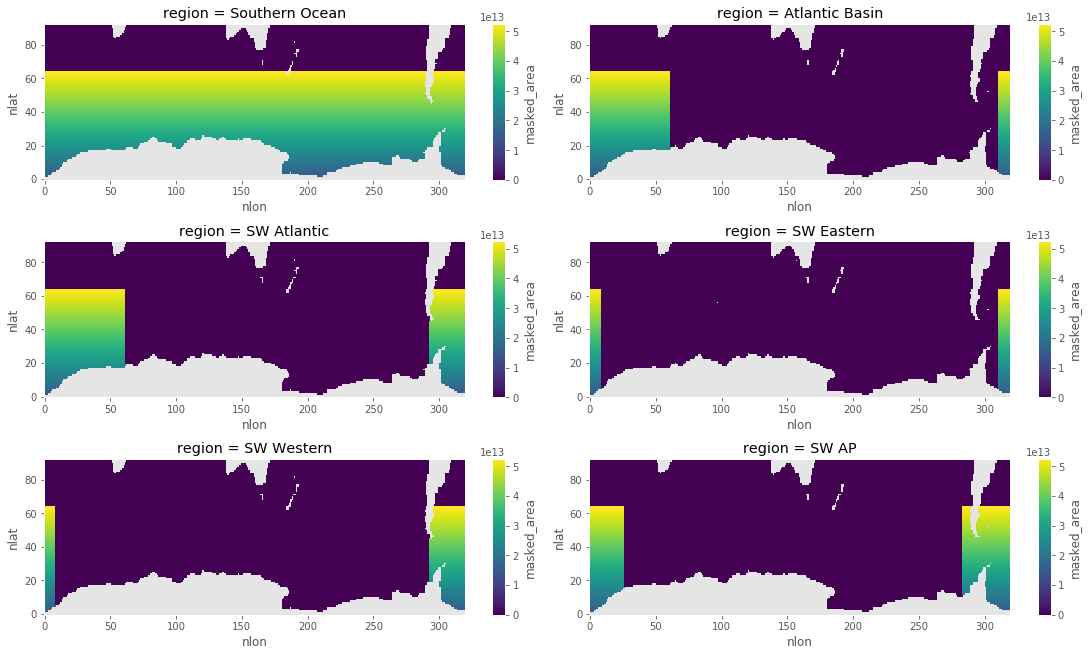

In [10]:
# Check and see if it worked:
ncol = int(np.sqrt(nregion))
nrow = int(nregion/ncol) + min(1, nregion%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(15, 3*nrow),
                       constrained_layout=True)

for i, region in enumerate(masked_area.region.values):
    plt.axes(ax.ravel()[i])
    masked_area.sel(region=region).plot()
    plt.savefig('figures/regions-recalc-plot-t.png', transparent = True)

In [28]:
masked_area

<xarray.DataArray 'masked_area' (region: 6, nlat: 93, nlon: 320)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781

In [41]:
test = ds_djf.expand_dims(masked_area)

TypeError: unhashable type: 'DataArray'

## Longitudinal Means

In [37]:
sw_djf = ds_djf.where(so_logic & ((grid.TLONG > 290) | (grid.TLONG < 30)))
sw_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length     float64 40.0
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

In [38]:
ds_djf_za = sw_djf.mean('nlon').mean('member_id')
ds_djf_za

<xarray.Dataset>
Dimensions:   (nlat: 93, time: 180)
Coordinates:
    length    float64 40.0
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: nlat
Data variables:
    SST       (time, nlat) float64 dask.array<chunksize=(180, 93), meta=np.ndarray>
    Chl_surf  (time, nlat) float64 dask.array<chunksize=(180, 93), meta=np.ndarray>
    KGP       (time, nlat) float64 dask.array<chunksize=(180, 93), meta=np.ndarray>

In [39]:
v = 'KGP'

thresh_val = 0
lat = ds_djf.TLAT.values[:, 0]

LAT_of_val = xr.DataArray(np.ones((len(ds_djf_za.time)))*np.nan,
                          dims=('time'),
                          coords={'time': ds_djf.time},
                          attrs={'long_name': 'Latitude of threshold'}
                         )

x = ds_djf_za[v].values

for l in range(len(ds_djf_za.time)):
    Iabv = np.where(x[l, :] < thresh_val)[0] #if you set to `<=` then it fails and returns a flat line
    ndx = [Iabv[0]-1, Iabv[0]]
    LAT_of_val.values[l] = np.interp(thresh_val, x[l, ndx], lat[ndx])

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


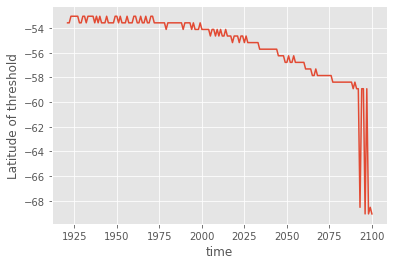

In [40]:
LAT_of_val.plot()